<a href="https://colab.research.google.com/github/quimHM/QHM_TFG_repository/blob/main/MAB_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#https://towardsdatascience.com/multi-armed-bandits-and-reinforcement-learning-dc9001dcb8da
#https://towardsdatascience.com/the-upper-confidence-bound-ucb-bandit-algorithm-c05c2bf4c13f

#https://github.com/WhatIThinkAbout/BabyRobot/tree/master/Multi_Armed_Bandits

In [3]:
# import modules 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
%matplotlib inline

In [4]:
class eps_bandit:
    '''
    epsilon-greedy k-bandit problem
    
    Inputs
    =====================================================
    k: number of arms (int)
    eps: probability of random action 0 < eps < 1 (float)
    iters: number of steps (int)
    mu: set the average rewards for each of the k-arms.
        Set to "random" for the rewards to be selected from
        a normal distribution with mean = 0. 
        Set to "sequence" for the means to be ordered from 
        0 to k-1.
        Pass a list or array of length = k for user-defined
        values.
    '''
    
    def __init__(self, k, eps, iters, mu='random'):
        # Number of arms
        self.k = k
        # Search probability
        self.eps = eps
        # Number of iterations
        self.iters = iters
        # Step count
        self.n = 0
        # Step count for each arm
        self.k_n = np.zeros(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_reward = np.zeros(k)
        
        if type(mu) == list or type(mu).__module__ == np.__name__:
            # User-defined averages            
            self.mu = np.array(mu)
        elif mu == 'random':
            # Draw means from probability distribution
            self.mu = np.random.normal(0, 1, k)
        elif mu == 'sequence':
            # Increase the mean for each arm by one
            self.mu = np.linspace(0, k-1, k)
        
    def pull(self):
        # Generate random number
        p = np.random.rand()
        if self.eps == 0 and self.n == 0:
            a = np.random.choice(self.k)
        elif p < self.eps:
            # Randomly select an action
            a = np.random.choice(self.k)
        else:
            # Take greedy action
            a = np.argmax(self.k_reward)
            
        reward = np.random.normal(self.mu[a], 1)
        
        # Update counts
        self.n += 1
        self.k_n[a] += 1
        
        # Update total
        self.mean_reward = self.mean_reward + (
            reward - self.mean_reward) / self.n
        
        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (
            reward - self.k_reward[a]) / self.k_n[a]
        
    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward
            
    def reset(self):
        # Resets results while keeping settings
        self.n = 0
        self.k_n = np.zeros(k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(k)

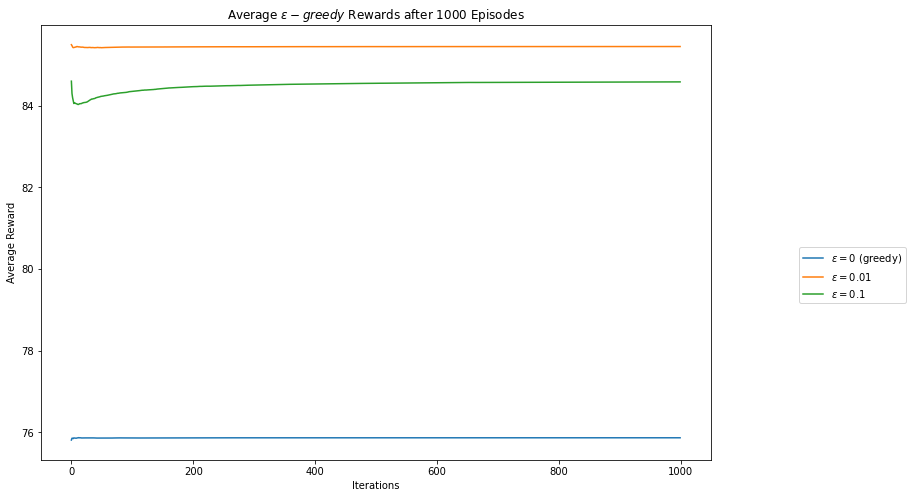

In [5]:
k = 8
iters = 1000

eps_0_rewards = np.zeros(iters)
eps_01_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)

hmda_mu = [85.55, 81.93, 82.84, 79.94, 71.03, 66.35, 74.71, 67.31]

episodes = 1000
# Run experiments
for i in range(episodes):
    # Initialize bandits
    eps_0 = eps_bandit(k, 0, iters, hmda_mu)
    eps_01 = eps_bandit(k, 0.01, iters, eps_0.mu.copy())
    eps_1 = eps_bandit(k, 0.1, iters, eps_0.mu.copy())
    
    # Run experiments
    eps_0.run()
    eps_01.run()
    eps_1.run()
    
    # Update long-term averages
    eps_0_rewards = eps_0_rewards + (
        eps_0.reward - eps_0_rewards) / (i + 1)
    eps_01_rewards = eps_01_rewards + (
        eps_01.reward - eps_01_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (
        eps_1.reward - eps_1_rewards) / (i + 1)
    
plt.figure(figsize=(12,8))
plt.plot(eps_0_rewards, label="$\epsilon=0$ (greedy)")
plt.plot(eps_01_rewards, label="$\epsilon=0.01$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-greedy$ Rewards after " + str(episodes) 
    + " Episodes")
plt.show()

In [6]:
print(eps_01.k_n)

[996.   2.   0.   0.   1.   0.   1.   0.]


## **RELLEVANT A PARTIR D'AQUÍ**

In [7]:
class PowerSocket:
    """ the base power socket class """
    
    def __init__(self, q, cl, var=1):                
        self.q = q        # the true reward value 
        self.confidence_level = cl          
        self.var = var   
        self.initialize() # reset the socket
        
    def initialize(self):
        self.Q = 0   # the estimate of this socket's reward value                
        self.n = 0   # the number of times this socket has been tried        
    
    def charge(self):
        """ return a random amount of charge """
        
        # the reward is a guassian distribution with unit variance around the true
        # value 'q'
        value = self.var * np.random.randn() + self.q        
        
        # never allow a charge less than 0 to be returned        
        return 0 if value < 0 else value
               
    def update(self,R):
        """ update this socket after it has returned reward value 'R' """     
    
        # increment the number of times this socket has been tried
        self.n += 1

        # the new estimate of the mean is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R

    def uncertainty(self, t): 
        """ calculate the uncertainty in the estimate of this socket's mean """
        if self.n == 0: return float('inf')                         
        return self.confidence_level * (np.sqrt(np.log(t) / self.n))         
        
    def sample(self,t):
        """ the UCB reward is the estimate of the mean reward plus its uncertainty """
        return self.Q + self.uncertainty(t) 

In [9]:
# return the index of the largest value in the supplied list
# - arbitrarily select between the largest values in the case of a tie
# (the standard np.argmax just chooses the first value in the case of a tie)
def random_argmax(value_list):
  """ a random tie-breaking argmax"""
  values = np.asarray(value_list)
  return np.argmax(np.random.random(values.shape) * (values==values.max()))


In [10]:
class SocketTester():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket, socket_order, confidence_level):  
        
        # create supplied socket type with a mean value defined by socket order 
        self.sockets = [socket(q, confidence_level) for q in socket_order]     
        
        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        self.number_of_stats = 2                 
            
    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """
        
        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps
        
        # reset the actual number of steps that the test ran for
        self.total_steps = 0
        
        # monitor the total reward obtained over the run
        self.total_reward = 0
        
        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = []
           
        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1, 
                                            self.number_of_sockets, 
                                            self.number_of_stats))
        
        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()
            
                                
    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """
        
        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward   
        
        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)
        
        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)        
        
        
    def get_socket_stats( self, t ):
        """ get the current information from each socket """        
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats     
    
    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)
    
    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep
    
    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep
    
    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]  
    
    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]          
                
    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)        
    
    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps
    
    def select_socket( self, t ):
        """ Greedy Socket Selection"""
        
        # choose the socket with the current highest mean reward or arbitrarily
        # select a socket in the case of a tie            
        socket_index = random_argmax([socket.sample(t+1) for socket in self.sockets]) 
        return socket_index     
    
    
    def run( self, number_of_steps, maximum_total_reward = float('inf')):  
        """ perform a single run, over the set of sockets, 
            for the defined number of steps """
        
        # reset the run counters
        self.initialize_run(number_of_steps)
        
        # loop for the specified number of time-steps
        for t in range(number_of_steps):

            # get information about all sockets at the start of the time step
            self.socket_stats[t] = self.get_socket_stats(t)            
            
            # select a socket
            socket_index = self.select_socket(t)
            
            # charge from the chosen socket and update its mean reward value
            self.charge_and_update(socket_index)
            
            # test if the accumulated total reward is greater than the maximum
            if self.total_reward > maximum_total_reward:
                break
       
        # save the actual number of steps that have been run
        self.total_steps = t    
    
        # get the stats for each socket at the end of the run        
        self.socket_stats[t+1] = self.get_socket_stats(t+1)           
        
        return self.total_steps, self.total_reward
  

In [11]:
test = SocketTester(PowerSocket, [85.55, 81.93, 82.84, 79.94, 71.03, 66.35, 74.71, 67.31], 5)
test.run(1000)
test.get_number_of_trials()[-1]

array([961.,  10.,  20.,   4.,   1.,   1.,   2.,   1.])

In [12]:
class SocketTesterBatch():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket, socket_order, confidence_level):  
        
        # create supplied socket type with a mean value defined by socket order 
        self.sockets = [socket(q, confidence_level) for q in socket_order]     
        
        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        self.number_of_stats = 2                 
            
    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """
        
        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps
        
        # reset the actual number of steps that the test ran for
        self.total_steps = 0
        
        # monitor the total reward obtained over the run
        self.total_reward = 0
        
        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = []
           
        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1, 
                                            self.number_of_sockets, 
                                            self.number_of_stats))
        
        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()
            
                                
    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """
        
        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward   
        
        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)
        
        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)        
        
        
    def get_socket_stats( self, t ):
        """ get the current information from each socket """        
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats     
    
    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)
    
    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep
    
    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep
    
    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]  
    
    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]          
                
    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)        
    
    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps
    
    def select_socket( self, t ):
        """ Greedy Socket Selection"""
        
        # choose the socket with the current highest mean reward or arbitrarily
        # select a socket in the case of a tie            
        mask = [self.get_number_of_trials()[t][i]<self.possibles[i] for i in range(len(self.sockets))]
        #print(mask)
        available = [self.sockets[i] for i in range(len(self.sockets)) if (mask[i])]
        socket_max = random_argmax([socket.sample(t+1) for socket in available]) 
        #print(socket_max)
        socket_index = self.sockets.index(available[socket_max])
        return socket_index     
    
    def return_increments(self, decisions_to_consider):
        presence = np.array([i/len(decisions_to_consider) for i in self.possibles])
        selected_presence = np.array(self.get_socket_percentages())
        diff = np.subtract(selected_presence, presence)
        #print(diff)
        #print(diff.sum())
        return diff
    
    def run( self, decisions_to_consider, max_percent_decisions=1, prints_bool = True):  
        """ perform a single run, over the set of sockets, 
            for the defined number of steps """
        
        # reset the run counters
        self.initialize_run(len(decisions_to_consider))

        self.possibles = [0]*8 #TODO: DEPENDS ON N OF CLUSTER (DECISIONS.UNIQUE() ISNT ENOUGH BECAUSE IT CAN LACK SOME INSTANCES)
        for i in np.unique(np.array(decisions_to_consider)):
          self.possibles[i] = decisions_to_consider.count(i) 

        usos = 0
        usos_maxims = math.floor(max_percent_decisions*len(decisions_to_consider))
        #print(usos_maxims)

        # loop for the specified number of time-steps
        for t in range(len(decisions_to_consider)):

            # get information about all sockets at the start of the time step
            self.socket_stats[t] = self.get_socket_stats(t)            
            
            # select a socket
            socket_index = self.select_socket(t)
            #if(decisions_to_consider[t]==socket_index):
            if(self.get_number_of_trials()[t][socket_index]<self.possibles[socket_index]):
              # charge from the chosen socket and update its mean reward value
              self.charge_and_update(socket_index)
              usos+=1
              
              if usos > usos_maxims:
                  #print(usos,usos_maxims)
                  break
        # save the actual number of steps that have been run
        self.total_steps = t    
    
        # get the stats for each socket at the end of the run        
        self.socket_stats[t+1] = self.get_socket_stats(t+1)           
        
        if(prints_bool):
          #print("Reward distribution:",[s.q for s in self.sockets])
          #print("Intances of each cluster:",self.possibles)
          print("Presence of each in batch (%):",[100*i/len(decisions_to_consider) for i in self.possibles])
          #print("Times selected:",self.get_number_of_trials()[t])
          print("Relative approval rate (%):",[round(100*self.get_number_of_trials()[t][i]/self.possibles[i],2) if self.possibles[i]>0.0 else 0.0 for i in range(len(self.possibles))])
          print("Percentage over total selected (%):",[round(100*p,2) for p in self.get_socket_percentages()])
          #print("For a total reward:",self.total_reward)


        return self.total_steps, self.total_reward, self.return_increments(decisions_to_consider)
  

In [13]:
import math
import random

In [14]:
test2 = SocketTesterBatch(PowerSocket, np.array([.8555, .8193, .8284, .7994, .7103, .6635, .7471, .6731])*100, 5)

decisions = random.choices(range(8), k=1000)
ts,tr,_ = test2.run(decisions)

Presence of each in batch (%): [10.2, 12.1, 12.3, 13.5, 14.1, 13.0, 12.6, 12.2]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 100.0, 99.23, 100.0, 100.0]
Percentage over total selected (%): [10.21, 12.11, 12.31, 13.51, 14.11, 12.91, 12.61, 12.21]


In [15]:
ts,tr,_ = test2.run(decisions, 0.8)

Presence of each in batch (%): [10.2, 12.1, 12.3, 13.5, 14.1, 13.0, 12.6, 12.2]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 100.0, 16.15, 100.0, 25.41]
Percentage over total selected (%): [12.75, 15.12, 15.38, 16.88, 17.62, 2.62, 15.75, 3.88]


In [16]:
sample_bias = [0.555, 0.24, 0.023, 0.011, 0.087, 0.081, 0.001, 0.001]
sample_bias_decisions = random.choices(range(8),weights=sample_bias,k=1000)
#print(sample_bias_decisions)
ts,tr,_ = test2.run(sample_bias_decisions, 0.8)

Presence of each in batch (%): [54.2, 25.3, 2.1, 1.0, 9.5, 7.9, 0.0, 0.0]
Relative approval rate (%): [100.0, 88.54, 100.0, 100.0, 2.11, 1.27, 0.0, 0.0]
Percentage over total selected (%): [67.75, 28.0, 2.62, 1.25, 0.25, 0.12, 0.0, 0.0]


###**NON-STATIC**

In [17]:
#def f(probs, val, ind):
#    probs[ind] += val
#    mask = np.ones(len(probs), bool)
#    mask[ind] = False
#    probs[mask] -= val / (len(probs) - 1)
#    return np.clip(probs, 0, np.infty) / np.sum(np.clip(probs, 0, np.infty))

In [18]:
def cummulative_sample(tester,iter,orig, coef):
  instances_distribution = np.array(orig)
  for i in range(iter):
    pbool=False
    if(i%math.ceil(iter/4)==0 or i==iter-1):
      print(i)
      #print(list(instances_distribution))
      pbool=True

    decisions = random.choices(range(8),weights=list(instances_distribution),k=1000)
    ts,tr,ti = tester.run(decisions, 0.8, pbool)
    
    #for i in range(len(ti)):
    #  instances_distribution = f(instances_distribution,ti[i],i)
    instances_distribution = np.add(instances_distribution,ti*coef)
    instances_distribution = np.clip(instances_distribution,0,None)
    instances_distribution = instances_distribution / instances_distribution.sum()

In [19]:
o_sample_bias = [0.555, 0.24, 0.023, 0.011, 0.087, 0.081, 0.001, 0.001]
cummulative_sample(test2,35,o_sample_bias,0.05)

0
Presence of each in batch (%): [56.3, 25.3, 2.3, 0.3, 7.9, 7.7, 0.2, 0.0]
Relative approval rate (%): [100.0, 81.42, 100.0, 100.0, 2.53, 1.3, 100.0, 0.0]
Percentage over total selected (%): [70.38, 25.75, 2.88, 0.38, 0.25, 0.12, 0.25, 0.0]
9
Presence of each in batch (%): [63.4, 22.9, 2.1, 1.4, 5.3, 4.7, 0.1, 0.1]
Relative approval rate (%): [100.0, 55.02, 100.0, 100.0, 3.77, 2.13, 100.0, 100.0]
Percentage over total selected (%): [79.25, 15.75, 2.62, 1.75, 0.25, 0.12, 0.12, 0.12]
18
Presence of each in batch (%): [70.6, 18.6, 2.6, 1.4, 3.0, 3.6, 0.1, 0.1]
Relative approval rate (%): [100.0, 29.57, 100.0, 64.29, 3.33, 2.78, 100.0, 100.0]
Percentage over total selected (%): [88.25, 6.88, 3.25, 1.12, 0.12, 0.12, 0.12, 0.12]
27
Presence of each in batch (%): [77.8, 13.4, 2.8, 1.2, 2.1, 2.3, 0.1, 0.3]
Relative approval rate (%): [98.07, 5.97, 71.43, 41.67, 4.76, 4.35, 100.0, 33.33]
Percentage over total selected (%): [95.38, 1.0, 2.5, 0.62, 0.12, 0.12, 0.12, 0.12]
34
Presence of each in 

In [20]:
no_sample_bias = [1/8]*8
cummulative_sample(test2,35,no_sample_bias,0.05)

0
Presence of each in batch (%): [13.4, 12.6, 12.7, 13.3, 13.4, 11.0, 11.0, 12.6]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 100.0, 10.0, 100.0, 19.84]
Percentage over total selected (%): [16.75, 15.75, 15.88, 16.62, 16.75, 1.38, 13.75, 3.12]
9
Presence of each in batch (%): [14.4, 13.3, 15.0, 13.7, 12.8, 8.1, 13.7, 9.0]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 69.53, 4.94, 100.0, 6.67]
Percentage over total selected (%): [18.0, 16.62, 18.75, 17.12, 11.12, 0.5, 17.12, 0.75]
18
Presence of each in batch (%): [14.4, 15.8, 15.6, 14.7, 11.8, 5.1, 16.9, 5.7]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 15.25, 5.88, 100.0, 8.77]
Percentage over total selected (%): [18.0, 19.75, 19.5, 18.38, 2.25, 0.38, 21.12, 0.62]
27
Presence of each in batch (%): [16.8, 15.4, 19.1, 15.7, 7.7, 3.3, 17.7, 4.3]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 11.69, 9.09, 65.54, 4.65]
Percentage over total selected (%): [21.0, 19.25, 23.88, 19.62, 1.12, 0.38, 

In [21]:
no_sample_bias = [1/8]*8
cummulative_sample(test2,150,no_sample_bias,0.05)

0
Presence of each in batch (%): [13.9, 12.3, 12.6, 13.9, 13.0, 12.4, 9.5, 12.4]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 100.0, 16.94, 100.0, 21.77]
Percentage over total selected (%): [17.38, 15.38, 15.75, 17.38, 16.25, 2.62, 11.88, 3.38]
38
Presence of each in batch (%): [18.5, 19.2, 22.1, 18.0, 4.0, 2.0, 13.6, 2.6]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 10.0, 10.0, 10.29, 7.69]
Percentage over total selected (%): [23.12, 24.0, 27.62, 22.5, 0.5, 0.25, 1.75, 0.25]
76
Presence of each in batch (%): [31.6, 24.8, 31.4, 8.5, 0.5, 0.7, 2.3, 0.2]
Relative approval rate (%): [100.0, 56.85, 100.0, 25.88, 40.0, 14.29, 13.04, 50.0]
Percentage over total selected (%): [39.5, 17.62, 39.25, 2.75, 0.25, 0.12, 0.38, 0.12]
114
Presence of each in batch (%): [53.0, 10.7, 33.3, 1.9, 0.6, 0.2, 0.3, 0.0]
Relative approval rate (%): [100.0, 72.9, 52.55, 57.89, 33.33, 50.0, 100.0, 0.0]
Percentage over total selected (%): [66.25, 9.75, 21.88, 1.38, 0.25, 0.12, 0.38, 0.0]
1

In [22]:
def nonstatic(iter, rewards_d_o, r_coef, instances_d_o, i_coef):
  rewards_d = np.array(rewards_d_o)
  instances_d = np.array(instances_d_o)

  #iter = 1000
  for i in range(iter):
    pbool=False
    if(i%math.ceil(iter/4)==0 or i==iter-1):
        print(i)
        #print(list(instances_distribution))
        pbool=True

    updated_test = SocketTesterBatch(PowerSocket, list(rewards_d), 5)
    decisions = random.choices(range(8),weights=list(instances_d),k=1000)
    ts,tr,ti = updated_test.run(decisions, 0.8, pbool)

    increments = ti
    #increments = np.subtract(np.array(updated_test.get_socket_percentages()),0.5)
    #print(increments)

    rewards_d = np.add(rewards_d,increments*r_coef*100)
    rewards_d = np.clip(rewards_d,0,100)
    #print(rewards_d)

    instances_d = np.add(instances_d,increments*i_coef)
    instances_d = np.clip(instances_d,0,None)
    instances_d = instances_d / instances_d.sum()

In [23]:
rewards_bias = np.array([.8555, .8193, .8284, .7994, .7103, .6635, .7471, .6731])*100
rewards_nonbias = [100/2]*8

instances_bias = [0.555, 0.24, 0.023, 0.011, 0.087, 0.081, 0.001, 0.001]
instances_nonbias = [1/8]*8

In [24]:
nonstatic(100, rewards_nonbias, 0, instances_nonbias, 0)

0
Presence of each in batch (%): [11.8, 12.4, 12.9, 14.2, 12.0, 11.5, 11.4, 13.8]
Relative approval rate (%): [100.0, 90.32, 90.7, 64.08, 82.5, 62.61, 65.79, 84.06]
Percentage over total selected (%): [14.75, 14.0, 14.62, 11.38, 12.38, 9.0, 9.38, 14.5]
25
Presence of each in batch (%): [12.8, 11.2, 12.8, 11.9, 10.1, 12.0, 15.3, 13.9]
Relative approval rate (%): [82.03, 83.04, 78.91, 100.0, 100.0, 61.67, 59.48, 83.45]
Percentage over total selected (%): [13.12, 11.62, 12.62, 14.88, 12.62, 9.25, 11.38, 14.5]
50
Presence of each in batch (%): [12.3, 12.5, 11.1, 12.3, 13.6, 14.0, 12.7, 11.5]
Relative approval rate (%): [84.55, 87.2, 69.37, 95.12, 58.82, 83.57, 70.08, 93.04]
Percentage over total selected (%): [13.0, 13.63, 9.62, 14.62, 10.0, 14.62, 11.12, 13.38]
75
Presence of each in batch (%): [12.3, 11.4, 12.9, 13.5, 12.5, 12.3, 12.0, 13.1]
Relative approval rate (%): [82.93, 76.32, 80.62, 89.63, 55.2, 85.37, 91.67, 77.86]
Percentage over total selected (%): [12.75, 10.88, 13.0, 15.12, 

In [25]:
nonstatic(2500, rewards_nonbias, 0, instances_bias, 0.01)

0
Presence of each in batch (%): [57.4, 21.4, 2.4, 0.9, 10.0, 7.7, 0.2, 0.0]
Relative approval rate (%): [65.16, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 0.0]
Percentage over total selected (%): [46.75, 26.75, 3.0, 1.12, 12.5, 9.62, 0.25, 0.0]


KeyboardInterrupt: ignored

In [ ]:
nonstatic(100, rewards_bias, 0, instances_nonbias, 0)

In [ ]:
nonstatic(100, rewards_bias, 0.1, instances_nonbias, 0)

In [ ]:
nonstatic(100, rewards_bias, 0, instances_bias, 0.01)

In [ ]:
nonstatic(100, rewards_bias, 0.01, instances_bias, 0)

In [ ]:
nonstatic(100, rewards_bias, 0.01, instances_bias, 0.01)

###**SOLUTION?**

In [26]:
class SocketTesterBatchSOLUTION():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket, socket_order, confidence_level, sub_opt):  
        
        self.subopt_coef = sub_opt

        # create supplied socket type with a mean value defined by socket order 
        self.sockets = [socket(q, confidence_level) for q in socket_order]     
        
        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        self.number_of_stats = 2                 
            
    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """
        
        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps
        
        # reset the actual number of steps that the test ran for
        self.total_steps = 0
        
        # monitor the total reward obtained over the run
        self.total_reward = 0
        
        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = []
           
        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1, 
                                            self.number_of_sockets, 
                                            self.number_of_stats))
        
        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()
            
                                
    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """
        
        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward   
        
        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)
        
        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)        
        
        
    def get_socket_stats( self, t ):
        """ get the current information from each socket """        
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats     
    
    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)
    
    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep
    
    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep
    
    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]  
    
    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]          
                
    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)        
    
    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps
    
    def select_socket( self, t ):
        """ Greedy Socket Selection"""
        #CONSTRAINT A
        curr_percentages = self.socket_stats[:,:,1][t]/t
        mean_percentages = np.mean(curr_percentages)
        dif_percentages = np.subtract(mean_percentages,self.socket_stats[:,:,1][t]/t)

        #CONSTRAINT B
        mean_selections = np.mean(self.get_number_of_trials()[t])
        dif_selections = np.subtract(mean_selections,self.get_number_of_trials()[t])

        #DUES CONSTRAINTS, UNA PER PERCENTATGES, L'ALTRE n SELECTIONS
        #dif = dif_percentages #rang 10-30-50
        dif = dif_selections   #rang 0-0.01-0.1

        #print(dif)

        # choose the socket with the current highest mean reward or arbitrarily
        # select a socket in the case of a tie            
        mask = [self.get_number_of_trials()[t][i]<self.possibles[i] for i in range(len(self.sockets))]
        #print(mask)
        available_sockets = [self.sockets[s] for s in range(len(self.sockets)) if (mask[s])]
        available = [i for i in range(len(self.sockets)) if (mask[i])]

        socket_max = random_argmax([self.sockets[socket].sample(t+1)+self.subopt_coef*dif[socket] for socket in available]) 
        #socket_max = random_argmax([self.sockets[socket].sample(t+1) for socket in available]) 

        #print(socket_max)
        socket_index = self.sockets.index(available_sockets[socket_max])
        return socket_index     
    
    def return_increments(self, decisions_to_consider):
        presence = np.array([i/len(decisions_to_consider) for i in self.possibles])
        selected_presence = np.array(self.get_socket_percentages())
        diff = np.subtract(selected_presence, presence)
        #print(diff)
        #print(diff.sum())
        return diff
    
    def run( self, decisions_to_consider, max_percent_decisions=1, prints_bool = True):  
        """ perform a single run, over the set of sockets, 
            for the defined number of steps """
        
        # reset the run counters
        self.initialize_run(len(decisions_to_consider))

        self.possibles = [0]*8 #TODO: DEPENDS ON N OF CLUSTER (DECISIONS.UNIQUE() ISNT ENOUGH BECAUSE IT CAN LACK SOME INSTANCES)
        for i in np.unique(np.array(decisions_to_consider)):
          self.possibles[i] = decisions_to_consider.count(i) 
        #print("possibles",self.possibles)

        usos = 0
        usos_maxims = math.floor(max_percent_decisions*len(decisions_to_consider))
        #print(usos_maxims)

        # loop for the specified number of time-steps
        for t in range(1,len(decisions_to_consider)):

            # get information about all sockets at the start of the time step
            self.socket_stats[t] = self.get_socket_stats(t)            
            
            # select a socket
            socket_index = self.select_socket(t)
            #if(decisions_to_consider[t]==socket_index):
            if(self.get_number_of_trials()[t][socket_index]<self.possibles[socket_index]):
              # charge from the chosen socket and update its mean reward value
              self.charge_and_update(socket_index)
              usos+=1
              
              if usos > usos_maxims:
                  #print(usos,usos_maxims)
                  break
        # save the actual number of steps that have been run
        self.total_steps = t    
    
        # get the stats for each socket at the end of the run        
        self.socket_stats[t+1] = self.get_socket_stats(t+1)           
        
        if(prints_bool):
          #print("possibles",self.possibles)
          #print("Reward distribution:",[s.q for s in self.sockets])
          #print("Intances of each cluster:",self.possibles)
          print("Presence of each in batch (%):",[100*i/len(decisions_to_consider) for i in self.possibles])
          print("Times selected:",self.get_number_of_trials()[t])
          print("Relative approval rate (%):",[round(100*self.get_number_of_trials()[t][i]/self.possibles[i],2) if self.possibles[i]>0.0 else 0.0 for i in range(len(self.possibles))])
          print("Percentage over total selected (%):",[round(100*p,2) for p in self.get_socket_percentages()])
          #print("For a total reward:",self.total_reward)
          #print(self.return_increments(decisions_to_consider))

        return self.total_steps, self.total_reward, self.return_increments(decisions_to_consider)
  

In [27]:
sol_test = SocketTesterBatch(PowerSocket, list(rewards_bias), 5)
decisions = random.choices(range(8),weights=list(instances_bias),k=1000)
ts,tr,ti = sol_test.run(decisions, 0.8, True)

Presence of each in batch (%): [53.9, 26.6, 2.2, 1.2, 8.1, 7.7, 0.2, 0.1]
Relative approval rate (%): [100.0, 83.08, 100.0, 100.0, 2.47, 1.3, 100.0, 100.0]
Percentage over total selected (%): [67.38, 27.62, 2.75, 1.5, 0.25, 0.12, 0.25, 0.12]


In [28]:
sol_test = SocketTesterBatchSOLUTION(PowerSocket, list(rewards_bias), 5, 0)
decisions = random.choices(range(8),weights=list(instances_bias),k=1000)
ts,tr,ti = sol_test.run(decisions, 0.8, True)

Presence of each in batch (%): [54.1, 23.1, 2.8, 1.2, 9.7, 8.8, 0.0, 0.3]
Times selected: [541. 215.  28.  12.   2.   1.   0.   1.]
Relative approval rate (%): [100.0, 93.07, 100.0, 100.0, 2.06, 1.14, 0.0, 33.33]
Percentage over total selected (%): [67.54, 26.84, 3.5, 1.5, 0.25, 0.12, 0.0, 0.12]


In [29]:
sol_test = SocketTesterBatchSOLUTION(PowerSocket, list(rewards_bias), 5, 0.01)
decisions = random.choices(range(8),weights=list(instances_bias),k=1000)
ts,tr,ti = sol_test.run(decisions, 0.8, True)

Presence of each in batch (%): [55.4, 23.7, 2.8, 1.5, 8.4, 7.9, 0.1, 0.2]
Times selected: [537. 215.  28.  15.   2.   1.   1.   1.]
Relative approval rate (%): [96.93, 90.72, 100.0, 100.0, 2.38, 1.27, 100.0, 50.0]
Percentage over total selected (%): [67.04, 26.84, 3.5, 1.87, 0.25, 0.12, 0.12, 0.12]


In [30]:
sol_test = SocketTesterBatchSOLUTION(PowerSocket, list(rewards_bias), 5, 0.1)
decisions = random.choices(range(8),weights=list(instances_bias),k=1000)
ts,tr,ti = sol_test.run(decisions, 0.8, True)

Presence of each in batch (%): [54.7, 24.0, 2.6, 1.6, 8.9, 8.0, 0.0, 0.2]
Times selected: [347. 240.  26.  16.  89.  80.   0.   2.]
Relative approval rate (%): [63.44, 100.0, 100.0, 100.0, 100.0, 100.0, 0.0, 100.0]
Percentage over total selected (%): [43.32, 29.96, 3.25, 2.0, 11.11, 9.99, 0.0, 0.25]


In [31]:
#sol_test = SocketTesterBatchSOLUTION(PowerSocket, list(rewards_bias), 5, 50)
#decisions = random.choices(range(8),weights=list(instances_bias),k=1000)
#ts,tr,ti = sol_test.run(decisions, 0.8, True)

curr_percentages = self.socket_stats[:,:,1][t]/t
mean_percentages = np.mean(curr_percentages)
dif_percentages = np.subtract(mean_percentages,self.socket_stats[:,:,1][t]/t)

mean_selections = np.mean(self.get_number_of_trials()[t])
dif_selections = np.subtract(mean_selections,self.get_number_of_trials()[t])

#DUES CONSTRAINTS, UNA PER PERCENTATGES, L'ALTRE n SELECTIONS
//dif = dif_percentages #rang 10-30-50

dif = dif_selections   #rang 0-0.01-0.1

In [32]:
class SocketTesterBatchSOLUTION_var():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket, socket_qs, confidence_level, sub_opt, socket_vars):  
        
        self.subopt_coef = sub_opt

        # create supplied socket type with a mean value defined by socket order 
        self.sockets = [socket(socket_qs[s], confidence_level, socket_vars[s]) for s in range(len(socket_qs))]     
        
        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        self.number_of_stats = 2                 
            
    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """
        
        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps
        
        # reset the actual number of steps that the test ran for
        self.total_steps = 0
        
        # monitor the total reward obtained over the run
        self.total_reward = 0
        
        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = []
           
        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1, 
                                            self.number_of_sockets, 
                                            self.number_of_stats))
        
        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()
            
                                
    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """
        
        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward   
        
        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)
        
        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)        
        
        
    def get_socket_stats( self, t ):
        """ get the current information from each socket """        
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats     
    
    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)
    
    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep
    
    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep
    
    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]  
    
    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]          
                
    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)        
    
    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps
    
    def select_socket( self, t ):
        """ Greedy Socket Selection"""
        #CONSTRAINT A
        curr_percentages = self.socket_stats[:,:,1][t]/t
        mean_percentages = np.mean(curr_percentages)
        dif_percentages = np.subtract(mean_percentages,self.socket_stats[:,:,1][t]/t)

        #CONSTRAINT B
        mean_selections = np.mean(self.get_number_of_trials()[t])
        dif_selections = np.subtract(mean_selections,self.get_number_of_trials()[t])

        #CONSTRAINT C
        #presence = np.array([i/sum(self.possibles) for i in self.possibles])
        #selected_presence = np.array(self.socket_stats[:,:,1][t]/t)
        #dif_presence = np.subtract(presence,selected_presence)

        #DUES CONSTRAINTS, UNA PER PERCENTATGES, L'ALTRE n SELECTIONS
        #dif = dif_percentages #rang 10-30-50
        dif = dif_selections   #rang 0-0.01-0.1
        ###dif = dif_presence

        #print(dif)

        # choose the socket with the current highest mean reward or arbitrarily
        # select a socket in the case of a tie            
        mask = [self.get_number_of_trials()[t][i]<self.possibles[i] for i in range(len(self.sockets))]
        #print(mask)
        available_sockets = [self.sockets[s] for s in range(len(self.sockets)) if (mask[s])]
        available = [i for i in range(len(self.sockets)) if (mask[i])]

        samples = [self.sockets[socket].sample(t+1)+self.subopt_coef*dif[socket] for socket in available]
        """print()
        print("presence",presence)
        print("selected_presence",selected_presence)
        print("dif",dif)
        print("samples",samples)"""
        socket_max = random_argmax(samples) 
        #socket_max = random_argmax([self.sockets[socket].sample(t+1) for socket in available]) 

        #print(socket_max)
        socket_index = self.sockets.index(available_sockets[socket_max])
        return socket_index     
    
    def return_increments(self, decisions_to_consider):
        presence = np.array([i/len(decisions_to_consider) for i in self.possibles])
        selected_presence = np.array(self.get_socket_percentages())
        diff = np.subtract(selected_presence, presence)
        #print(diff)
        #print(diff.sum())
        return diff

    def return_increments_distr(self, decisions_to_consider):
        presence = np.array([i/len(decisions_to_consider) for i in self.possibles])
        selected_presence = np.array(self.get_socket_percentages())
        diff = np.subtract(selected_presence, presence)
        #print(diff)
        #print(diff.sum())
        return diff
    
    def run( self, decisions_to_consider, max_percent_decisions=1, prints_bool = True):  
        """ perform a single run, over the set of sockets, 
            for the defined number of steps """
        
        # reset the run counters
        self.initialize_run(len(decisions_to_consider))

        self.possibles = [0]*8 #TODO: DEPENDS ON N OF CLUSTER (DECISIONS.UNIQUE() ISNT ENOUGH BECAUSE IT CAN LACK SOME INSTANCES)
        for i in np.unique(np.array(decisions_to_consider)):
          self.possibles[i] = decisions_to_consider.count(i) 
        #print("possibles",self.possibles)

        usos = 0
        usos_maxims = math.floor(max_percent_decisions*len(decisions_to_consider))
        #print(usos_maxims)

        # loop for the specified number of time-steps
        for t in range(1,len(decisions_to_consider)):

            # get information about all sockets at the start of the time step
            self.socket_stats[t] = self.get_socket_stats(t)            
            
            # select a socket
            socket_index = self.select_socket(t)
            #if(decisions_to_consider[t]==socket_index):
            if(self.get_number_of_trials()[t][socket_index]<self.possibles[socket_index]):
              # charge from the chosen socket and update its mean reward value
              self.charge_and_update(socket_index)
              usos+=1
              
              if usos > usos_maxims:
                  #print(usos,usos_maxims)
                  break
        # save the actual number of steps that have been run
        self.total_steps = t    
    
        # get the stats for each socket at the end of the run        
        self.socket_stats[t+1] = self.get_socket_stats(t+1)           
        
        if(prints_bool):
          #print("possibles",self.possibles)
          #print("Reward distribution:",[s.q for s in self.sockets])
          #print("Intances of each cluster:",self.possibles)
          print("Presence of each in batch (%):",[100*i/len(decisions_to_consider) for i in self.possibles])
          print("Times selected:",self.get_number_of_trials()[t])
          print("Relative approval rate (%):",[round(100*self.get_number_of_trials()[t][i]/self.possibles[i],2) if self.possibles[i]>0.0 else 0.0 for i in range(len(self.possibles))])
          print("Percentage over total selected (%):",[round(100*p,2) for p in self.get_socket_percentages()])
          #print("For a total reward:",self.total_reward)
          #print(self.return_increments(decisions_to_consider))
          print("Estimates:",list(self.get_estimates()[t]))

        return self.total_steps, self.total_reward, self.return_increments(decisions_to_consider)
  

In [33]:
variances = [20]*8
#variances = [1]*8
sol_test = SocketTesterBatchSOLUTION_var(PowerSocket, list(rewards_bias), 5, 0, variances) #high variance+sampling bias super injust (la variance de classes menys popualtes afecta mes q altres)
decisions = random.choices(range(8),weights=list(instances_nonbias),k=1000)
ts,tr,ti = sol_test.run(decisions, 0.8, True)

Presence of each in batch (%): [13.0, 13.9, 12.1, 12.6, 11.6, 11.3, 12.8, 12.7]
Times selected: [130. 139. 121. 126. 116.   8. 128.  32.]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 100.0, 7.08, 100.0, 25.2]
Percentage over total selected (%): [16.23, 17.35, 15.11, 15.73, 14.48, 1.0, 15.98, 4.0]
Estimates: [83.29557472558827, 79.80379753907431, 84.14679775162921, 82.29507897726884, 71.87846068209595, 59.86491080009063, 75.23214941642084, 63.769748001262585]


In [34]:
def nonstatic_sol(iter, rewards_d_o, r_coef, instances_d_o, i_coef, sub_opt, s_variances):
  rewards_d = np.array(rewards_d_o)
  instances_d = np.array(instances_d_o)

  #iter = 1000
  for i in range(iter):
    pbool=False
    if(i%math.ceil(iter/4)==0 or i==iter-1):
        print(i)
        #print(list(instances_distribution))
        pbool=True

    updated_test = SocketTesterBatchSOLUTION_var(PowerSocket, list(rewards_d), 5, sub_opt, s_variances)
    decisions = random.choices(range(8),weights=list(instances_d),k=5000)
    ts,tr,ti = updated_test.run(decisions, 0.8, pbool)

    increments = ti
    #increments = np.subtract(np.array(updated_test.get_socket_percentages()),0.5)
    #print(increments)

    rewards_d = np.add(rewards_d,increments*r_coef*100)
    rewards_d = np.clip(rewards_d,0,100)
    #print(rewards_d)

    instances_d = np.add(instances_d,increments*i_coef)
    instances_d = np.clip(instances_d,0,None)
    instances_d = instances_d / instances_d.sum()

In [35]:
variances = [1]*8
nonstatic_sol(500, rewards_bias, 0.01, instances_bias, 0.01, 0, variances)

0
Presence of each in batch (%): [55.46, 23.08, 2.24, 1.22, 9.04, 8.78, 0.1, 0.08]
Times selected: [2.773e+03 1.079e+03 1.120e+02 2.800e+01 2.000e+00 1.000e+00 4.000e+00
 1.000e+00]
Relative approval rate (%): [100.0, 93.5, 100.0, 45.9, 0.44, 0.23, 80.0, 25.0]
Percentage over total selected (%): [69.31, 26.97, 2.8, 0.7, 0.05, 0.02, 0.1, 0.02]
Estimates: [85.52945254121418, 81.91900070919091, 82.78402510812002, 79.62609402522847, 72.01372321017809, 66.74622120955623, 74.57685576504825, 67.45328002071747]
125
Presence of each in batch (%): [74.74, 16.06, 3.06, 1.4, 2.36, 2.22, 0.12, 0.04]
Times selected: [3.737e+03 2.800e+01 1.530e+02 7.000e+01 2.000e+00 2.000e+00 6.000e+00
 2.000e+00]
Relative approval rate (%): [100.0, 3.49, 100.0, 100.0, 1.69, 1.8, 100.0, 100.0]
Percentage over total selected (%): [93.4, 0.7, 3.82, 1.75, 0.05, 0.05, 0.15, 0.05]
Estimates: [100.01187104951514, 72.50005027522924, 83.89949134996048, 79.97757513152227, 64.84560585576176, 61.11221769795081, 74.643553447463

In [36]:
variances = [1]*8
nonstatic_sol(500, rewards_bias, 0.01, instances_bias, 0.01, 0.1, variances)

0
Presence of each in batch (%): [55.2, 23.92, 2.44, 1.22, 8.62, 8.38, 0.12, 0.1]
Times selected: [1760. 1196.  122.   61.  431.  419.    6.    5.]
Relative approval rate (%): [63.77, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Percentage over total selected (%): [43.99, 29.89, 3.05, 1.52, 10.77, 10.47, 0.15, 0.12]
Estimates: [85.52221175196613, 81.97860387468697, 82.88314746806769, 79.77415660927117, 71.03148698062635, 66.4026989885998, 75.14468057691244, 67.63606925264408]
125
Presence of each in batch (%): [40.36, 31.42, 3.26, 1.32, 12.74, 10.64, 0.1, 0.16]
Times selected: [1201. 1388.  163.   66.  637.  532.    5.    8.]
Relative approval rate (%): [59.51, 88.35, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Percentage over total selected (%): [30.02, 34.69, 4.07, 1.65, 15.92, 13.3, 0.12, 0.2]
Estimates: [70.660057171472, 89.34589620708881, 83.53758912658435, 80.42954078084217, 74.2184521456911, 69.2307344922269, 74.27432419665249, 67.54695517857022]
250
Presence of each in batch 

In [37]:
variances = [10]*8
##(5000 per iter)
nonstatic_sol(1000, rewards_bias, 0.02, instances_bias, 0.02, 0.1, variances)

0
Presence of each in batch (%): [54.48, 24.48, 2.54, 1.14, 8.84, 8.26, 0.16, 0.1]
Times selected: [1724. 1224.  127.   57.  442.  413.    8.    5.]
Relative approval rate (%): [63.29, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Percentage over total selected (%): [43.09, 30.59, 3.17, 1.42, 11.05, 10.32, 0.2, 0.12]
Estimates: [85.41719013564952, 82.0242775469939, 83.52551173553964, 78.8234384519564, 70.48672351693246, 66.25079579892842, 74.26806807202847, 62.4791558643371]


KeyboardInterrupt: ignored

In [38]:
variances = [10]*8
nonstatic_sol(1000, rewards_bias, 0.04, instances_bias, 0.04, 100, variances)

0
Presence of each in batch (%): [57.38, 22.38, 2.44, 1.18, 8.16, 8.26, 0.06, 0.14]
Times selected: [1869. 1119.  122.   59.  408.  413.    3.    7.]
Relative approval rate (%): [65.14, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Percentage over total selected (%): [46.71, 27.97, 3.05, 1.47, 10.2, 10.32, 0.07, 0.17]
Estimates: [85.64061475131663, 82.09036917677778, 83.56061748170457, 81.0403726870004, 71.50568591504407, 65.9442244301862, 78.34738010325408, 71.25883971012564]


KeyboardInterrupt: ignored

In [39]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
import pandas as pd
import numpy as np

from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)
drive.mount(ROOT)

unpickled_df = pd.read_csv("/content/drive/MyDrive/TFG/hmda/state_AL-GA_actions_taken_1-3.csv")
print(unpickled_df.derived_sex.unique(),'\n',
unpickled_df.derived_race.unique(),'\n',
unpickled_df.derived_ethnicity.unique(),'\n',
unpickled_df.action_taken.unique())

subsample = unpickled_df                    

print(len(subsample.loc[subsample["action_taken"]==1]),len(subsample.loc[subsample["action_taken"]==3]))
subsample = subsample.loc[subsample["action_taken"].isin([1,3])]
subsample["action_taken"] = subsample["action_taken"].replace([3],[0])    
print("action:",subsample["action_taken"].unique())
print(len(subsample.loc[subsample["action_taken"]==1]),len(subsample.loc[subsample["action_taken"]==0]))

print("race pre:",subsample["derived_race"].unique())
subsample = subsample.loc[subsample["derived_race"].isin(["White","Black or African American"])]
subsample["derived_race"] = subsample["derived_race"].replace(["White","Black or African American"],[0,1])
print("race:",subsample["derived_race"].unique())

print("ethnicity pre:",subsample["derived_ethnicity"].unique())
subsample = subsample.loc[subsample["derived_ethnicity"].isin(['Not Hispanic or Latino','Hispanic or Latino'])]
subsample["derived_ethnicity"] = subsample["derived_ethnicity"].replace(['Not Hispanic or Latino','Hispanic or Latino'],[0,1])
print("ethnicity:",subsample["derived_ethnicity"].unique())

print("sex pre",subsample["derived_sex"].unique())
subsample = subsample.loc[subsample["derived_sex"].isin(['Male','Female'])]
subsample["derived_sex"] = subsample["derived_sex"].replace(['Male','Female'],[0,1])
print("sex:",subsample["derived_sex"].unique())


subsample = subsample.loc[subsample["interest_rate"]!='Exempt']
subsample["interest_rate"] = pd.to_numeric(subsample["interest_rate"] ) 

#print(len(subsample.loc[subsample["loan_to_value_ratio"]=='Exempt']))
subsample = subsample.loc[subsample["loan_to_value_ratio"]!='Exempt']
#print(len(subsample.loc[subsample["loan_to_value_ratio"]=='Exempt']))
#print(subsample["loan_to_value_ratio"])
subsample["loan_to_value_ratio"] = pd.to_numeric(subsample["loan_to_value_ratio"] )  
#print(subsample["loan_to_value_ratio"].mean())

subsample = subsample.loc[subsample["property_value"]!='Exempt']
subsample["property_value"] = pd.to_numeric(subsample["property_value"] ) 

print(len(subsample.loc[subsample["action_taken"]==1]),len(subsample.loc[subsample["action_taken"]==0]))

print(len(subsample))
#subsample = subsample[["loan_type", "property_type", "loan_purpose", "loan_amount_000s",
#                            "action_taken","applicant_ethnicity","applicant_race_1","applicant_sex",
#                           "applicant_income_000s"]]
print(len(subsample.loc[subsample["action_taken"]==1]),len(subsample.loc[subsample["action_taken"]==0]))
print(len(subsample),len(subsample.columns),subsample.isnull().values.sum())

#thr=0.25
#for col in subsample.columns:
#  if (subsample[col].isnull().sum()>thr*len(subsample)):
    #subsample.drop(columns=[col])
#    print(col)

#subsample = subsample.dropna(axis=1,thresh=thr*len(subsample))
#subsample = subsample.dropna(axis=0)

# Iterate over each column of cc_apps
for col in subsample.columns:
    # Check if the column is of object type
    if subsample[col].dtypes == 'object':
        # Impute with the most frequent value
        subsample = subsample.fillna(subsample[col].value_counts().index[0])


print(len(subsample.loc[subsample["action_taken"]==1]),len(subsample.loc[subsample["action_taken"]==0]))

# Count the number of NaNs in the dataset and print the counts to verify
print(len(subsample),len(subsample.columns),subsample.isnull().values.sum())
cols = [f_ for f_ in subsample.columns if subsample[f_].dtype != 'object']
features = cols

list_to_remove = ['action_taken','purchaser_type', 'activity_year',
                  'denial_reason_1','denial_reason_2','denial_reason_3','sequence_number','application_date_indicator']

features = list(set(cols).difference(set(list_to_remove)))

X = subsample[features]
y = subsample['action_taken']

# Import train_test_split
from sklearn.model_selection import train_test_split
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                y,
                                test_size=0.3,
                                random_state=2)

X_test1, X_test2, y_test1, y_test2 = train_test_split(X_test,
                                y_test,
                                test_size=0.33,
                                random_state=2)

scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(X)
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.fit_transform(X_test)
rescaledX_test1 = scaler.fit_transform(X_test1)
rescaledX_test2 = scaler.fit_transform(X_test2)

logreg = LogisticRegression(solver="liblinear")

scores_dict = cross_validate(logreg,rescaledX_train,y_train,cv=5, return_estimator=True)
best = scores_dict["estimator"][0] 


y_pred = best.predict(rescaledX_test1)
from collections import Counter
counterpred = Counter(y_pred)
countertest = Counter(y_test1)
counterall = Counter(y)
print(counterpred, countertest, counterall)
print("Accuracy of logistic regression classifier: ", best.score(rescaledX_test1, y_test1))


y_pred = best.predict(rescaledX_test2)
counterpred = Counter(y_pred)
countertest = Counter(y_test2)
counterall = Counter(y)
print(counterpred, countertest, counterall)
print("Accuracy of logistic regression classifier: ", best.score(rescaledX_test2, y_test2))

/content/drive
Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


['Male' 'Female' 'Joint' 'Sex Not Available'] 
 ['Asian' 'White' 'Black or African American' 'Race Not Available'
 '2 or more minority races' 'Joint' 'American Indian or Alaska Native'
 'Native Hawaiian or Other Pacific Islander' 'Free Form Text Only'] 
 ['Not Hispanic or Latino' 'Hispanic or Latino' 'Ethnicity Not Available'
 'Joint' 'Free Form Text Only'] 
 [1 3]
637571 150977
action: [1 0]
637571 150977
race pre: ['Asian' 'White' 'Black or African American' 'Race Not Available'
 '2 or more minority races' 'Joint' 'American Indian or Alaska Native'
 'Native Hawaiian or Other Pacific Islander' 'Free Form Text Only']
race: [0 1]
ethnicity pre: ['Not Hispanic or Latino' 'Hispanic or Latino' 'Joint'
 'Ethnicity Not Available' 'Free Form Text Only']
ethnicity: [0 1]
sex pre ['Female' 'Joint' 'Male' 'Sex Not Available']
sex: [1 0]
297078 77133
374211
297078 77133
374211 99 11416911
297078 77133
374211 99 0
Counter({1: 59047, 0: 16169}) Counter({1: 59642, 0: 15574}) Counter({1: 297078, 0: 7

In [40]:
import math
def partitions(n_partitions, X, y):
  X_partitions = []
  y_partitions = []
  size_partitions = math.floor(len(X)/n_partitions)
  for p in range(n_partitions):
    X_partitions.append(X[p*size_partitions:(p+1)*size_partitions])  
    y_partitions.append(y[p*size_partitions:(p+1)*size_partitions])
  print(len(X), [sum(len(item) for item in X_partitions)], len(X_partitions[0]))
  return X_partitions, y_partitions

In [41]:
def create_df(x,xcol,y,ycol):
  auxnparray = x.copy()
  newdf = pd.DataFrame(auxnparray, columns = xcol)
  newdf[ycol] = y.tolist()
  return newdf

In [42]:
def preproc(df):
  subgroups = []
  instances = []
  sensitive = ["derived_race","derived_ethnicity","derived_sex"]
  R = ["W","B"]
  E = ["NH","H"]
  S = ["M","F"]
  for option in [0,1]:
    for option2 in [0,1]:
      for option3 in [0,1]:
          subgroups.append(df.loc[((df[sensitive[0]]==option) & (df[sensitive[1]]==option2) & (df[sensitive[2]]==option3))])
          instances.append(len(subgroups[-1]))
  return subgroups, instances

In [70]:
from scipy.stats import norm

df = create_df(X,features,y,"action_taken")

mean1, std1 = norm.fit(df.loc[df["action_taken"]==1.0]["loan_amount"])

mean0, std0 = norm.fit(df.loc[df["action_taken"]==0.0]["loan_amount"])

print(mean1, std1)
print(mean0, std0)
print()
sg, ic = preproc(df)
for s in sg:
  approval_rate = len(s.loc[s["action_taken"]==1.0])/len(s)
  print(approval_rate)
  mu, std = norm.fit(s["loan_amount"])
  print(mu,std)

218105.0431199887 139481.95009278832
160005.25067091905 1105860.4324265125

0.8351500209501023
226709.22472476424 166779.32726755406
0.8159538417240692
188992.66871913 1018094.2364840672
0.817375020354991
210144.11333659012 117534.09872909547
0.7888888888888889
188379.08496732026 97116.36484512454
0.7132048203013751
199465.57990265882 124702.33091446564
0.6970787386341653
178265.8154381892 140000.80131986627
0.6884939195509823
200051.4499532273 117415.7428144394
0.6611328125
184667.96875 101521.08342728137


In [59]:
class PowerSocketReal:
    """ the base power socket class """
    
    def __init__(self, q, cl, var=1):                
        self.q = q        # the true reward value 
        self.confidence_level = cl          
        self.var = var   
        self.initialize() # reset the socket
        
    def initialize(self):
        self.Q = 0   # the estimate of this socket's reward value                
        self.n = 0   # the number of times this socket has been tried        
    
    def charge(self):
        """ return a random amount of charge """
        
        # the reward is a guassian distribution with unit variance around the true
        # value 'q'
        #value = self.var * np.random.randn() + self.q      

        #value = self.q.iloc[self.n]["action_taken"]

        #value = self.q["action_taken"].sample(n=1).iloc[0]

        sample = self.q.sample(n=1)
        if (sample["action_taken"].iloc[0]==1.0):
          value = sample["loan_amount"].iloc[0]
        else:
          value = 0.0

        # never allow a charge less than 0 to be returned        
        return 0 if value < 0 else value
               
    def update(self,R):
        """ update this socket after it has returned reward value 'R' """     
    
        # increment the number of times this socket has been tried
        self.n += 1

        # the new estimate of the mean is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R

    def uncertainty(self, t): 
        """ calculate the uncertainty in the estimate of this socket's mean """
        if self.n == 0: return float('inf')                         
        return self.confidence_level * (np.sqrt(np.log(t) / self.n))         
        
    def sample(self,t):
        """ the UCB reward is the estimate of the mean reward plus its uncertainty """
        return self.Q + self.uncertainty(t) 

In [44]:
class SocketTesterBatchReal():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket, socket_order, confidence_level):  
        
        # create supplied socket type with a mean value defined by socket order 
        self.sockets = [socket(q, confidence_level) for q in socket_order]     
        
        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        self.number_of_stats = 2                 
            
    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """
        
        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps
        
        # reset the actual number of steps that the test ran for
        self.total_steps = 0
        
        # monitor the total reward obtained over the run
        self.total_reward = 0
        
        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = []
           
        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1, 
                                            self.number_of_sockets, 
                                            self.number_of_stats))
        
        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()
            
                                
    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """
        
        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward   
        
        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)
        
        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)        
        
        
    def get_socket_stats( self, t ):
        """ get the current information from each socket """        
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats     
    
    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)
    
    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep
    
    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep
    
    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]  
    
    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]          
                
    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)        
    
    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps
    
    def select_socket( self, t ):
        """ Greedy Socket Selection"""
        
        # choose the socket with the current highest mean reward or arbitrarily
        # select a socket in the case of a tie            
        mask = [self.get_number_of_trials()[t][i]<self.possibles[i] for i in range(len(self.sockets))]
        #print(mask)
        available = [self.sockets[i] for i in range(len(self.sockets)) if (mask[i])]
        #print([socket.sample(t+1) for socket in available])
        socket_max = random_argmax([socket.sample(t+1) for socket in available]) 
        #print(socket_max)
        socket_index = self.sockets.index(available[socket_max])
        return socket_index     
    
    def return_increments(self, decisions_to_consider):
        presence = np.array([i/len(decisions_to_consider) for i in self.possibles])
        selected_presence = np.array(self.get_socket_percentages())
        diff = np.subtract(selected_presence, presence)
        #print(diff)
        #print(diff.sum())
        return diff
    
    def run( self, decisions_to_consider, class_count, max_percent_decisions=1, prints_bool = True):  
        """ perform a single run, over the set of sockets, 
            for the defined number of steps """
        
        for s in range(len(self.sockets)):
          self.sockets[s].q = decisions_to_consider[s]     

        # reset the run counters
        self.initialize_run(sum(class_count))

        self.possibles = class_count
        print(self.possibles)

        usos = 0
        usos_maxims = math.floor(max_percent_decisions*sum(class_count))
        #print(usos_maxims)

        # loop for the specified number of time-steps
        for t in range(sum(class_count)):

            # get information about all sockets at the start of the time step
            self.socket_stats[t] = self.get_socket_stats(t)            
            
            # select a socket
            socket_index = self.select_socket(t)
            #if(decisions_to_consider[t]==socket_index):
            if(self.get_number_of_trials()[t][socket_index]<self.possibles[socket_index]):
              # charge from the chosen socket and update its mean reward value
              self.charge_and_update(socket_index)
              usos+=1
              
              if usos > usos_maxims:
                  #print(usos,usos_maxims)
                  break
        # save the actual number of steps that have been run
        self.total_steps = t    
    
        # get the stats for each socket at the end of the run        
        self.socket_stats[t+1] = self.get_socket_stats(t+1)           
        
        if(prints_bool):
          #print("Reward distribution:",[s.q for s in self.sockets])
          #print("Intances of each cluster:",self.possibles)
          print("Presence of each in batch (%):",[100*i/sum(class_count) for i in self.possibles])
          #print("Times selected:",self.get_number_of_trials()[t])
          print("Relative approval rate (%):",[round(100*self.get_number_of_trials()[t][i]/self.possibles[i],2) if self.possibles[i]>0.0 else 0.0 for i in range(len(self.possibles))])
          print("Percentage over total selected (%):",[round(100*p,2) for p in self.get_socket_percentages()])
          #print("For a total reward:",self.total_reward)


        return self.total_steps, self.total_reward, self.return_increments(decisions_to_consider)

In [100]:
class SocketTesterBatchRealBudget():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket, socket_order, confidence_level):  
        
        # create supplied socket type with a mean value defined by socket order 
        self.sockets = [socket(q, confidence_level) for q in socket_order]     
        
        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        self.number_of_stats = 2                 
            
    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """
        
        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps
        
        # reset the actual number of steps that the test ran for
        self.total_steps = 0
        
        # monitor the total reward obtained over the run
        self.total_reward = 0
        
        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = []
           
        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1, 
                                            self.number_of_sockets, 
                                            self.number_of_stats))
        
        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()
            
                                
    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """
        
        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward  
        self.budget -= reward 
        
        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)
        
        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)        
        
        
    def get_socket_stats( self, t ):
        """ get the current information from each socket """        
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats     
    
    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)
    
    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep
    
    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep
    
    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]  
    
    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]          
                
    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)        
    
    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps
    
    def select_socket( self, t ):
        """ Greedy Socket Selection"""
        
        # choose the socket with the current highest mean reward or arbitrarily
        # select a socket in the case of a tie            
        mask = [self.get_number_of_trials()[t][i]<self.possibles[i] for i in range(len(self.sockets))]
        #print(mask)
        available = [self.sockets[i] for i in range(len(self.sockets)) if (mask[i])]
        #print([socket.sample(t+1) for socket in available])
        socket_max = random_argmax([socket.sample(t+1) for socket in available]) 
        #print(socket_max)
        socket_index = self.sockets.index(available[socket_max])
        return socket_index     
    
    def return_increments(self, decisions_to_consider):
        presence = np.array([i/len(decisions_to_consider) for i in self.possibles])
        selected_presence = np.array(self.get_socket_percentages())
        diff = np.subtract(selected_presence, presence)
        #print(diff)
        #print(diff.sum())
        return diff
    
    def run( self, decisions_to_consider, class_count, budget, prints_bool = True):  
        """ perform a single run, over the set of sockets, 
            for the defined number of steps """
        
        for s in range(len(self.sockets)):
          self.sockets[s].q = decisions_to_consider[s]     

        # reset the run counters
        self.initialize_run(sum(class_count))

        self.possibles = class_count
        print(self.possibles)

        usos = 0
        self.budget = budget
        #print(usos_maxims)

        # loop for the specified number of time-steps
        for t in range(sum(class_count)):

            # get information about all sockets at the start of the time step
            self.socket_stats[t] = self.get_socket_stats(t)            
            
            # select a socket
            socket_index = self.select_socket(t)
            #if(decisions_to_consider[t]==socket_index):
            if(self.get_number_of_trials()[t][socket_index]<self.possibles[socket_index]):
              # charge from the chosen socket and update its mean reward value
              self.charge_and_update(socket_index)
              usos+=1
            if self.budget-max(self.get_estimates()[t]) < 0:
              break
        # save the actual number of steps that have been run
        self.total_steps = t    
    
        # get the stats for each socket at the end of the run        
        self.socket_stats[t+1] = self.get_socket_stats(t+1)           
        
        if(prints_bool):
          #print("Reward distribution:",[s.q for s in self.sockets])
          #print("Intances of each cluster:",self.possibles)
          print("Presence of each in batch (%):",[100*i/sum(class_count) for i in self.possibles])
          #print("Times selected:",self.get_number_of_trials()[t])
          print("Relative approval rate (%):",[round(100*self.get_number_of_trials()[t][i]/self.possibles[i],2) if self.possibles[i]>0.0 else 0.0 for i in range(len(self.possibles))])
          print("Percentage over total selected (%):",[round(100*p,2) for p in self.get_socket_percentages()])
          #print("For a total reward:",self.total_reward)


        return self.total_steps, self.total_reward, self.return_increments(decisions_to_consider)

In [98]:
real_test = SocketTesterBatchReal(PowerSocketReal, [[0]]*8, 5)
print(real_test.sockets)


X_p, y_p = partitions(4,X,y)
for b in range(4):
  batch = create_df(X_p[b],features,y_p[b],"action_taken")
  sg, ic = preproc(batch)
  ts,tr,ti = real_test.run(sg, ic, 0.8, True)

[<__main__.PowerSocketReal object at 0x7fa1c2d97990>, <__main__.PowerSocketReal object at 0x7fa1c2d39e50>, <__main__.PowerSocketReal object at 0x7fa1c2d97c10>, <__main__.PowerSocketReal object at 0x7fa1c2d97ad0>, <__main__.PowerSocketReal object at 0x7fa1c2d97950>, <__main__.PowerSocketReal object at 0x7fa1c0844ad0>, <__main__.PowerSocketReal object at 0x7fa1c0844bd0>, <__main__.PowerSocketReal object at 0x7fa1c0844b10>]
374211 [374208] 93552


TypeError: ignored

In [127]:
real_test = SocketTesterBatchRealBudget(PowerSocketReal, [[0]]*8, 5)
print(real_test.sockets)


X_p, y_p = partitions(10,X,y)
for b in range(10):
  batch = create_df(X_p[b],features,y_p[b],"action_taken")
  budget = batch["loan_amount"].sum()
  sg, ic = preproc(batch)
  ts,tr,ti = real_test.run(sg, ic, 0.8*budget, True)

[<__main__.PowerSocketReal object at 0x7fa1c2b02bd0>, <__main__.PowerSocketReal object at 0x7fa1c2b02410>, <__main__.PowerSocketReal object at 0x7fa1c2b02910>, <__main__.PowerSocketReal object at 0x7fa1c2b02d10>, <__main__.PowerSocketReal object at 0x7fa1c2b02a90>, <__main__.PowerSocketReal object at 0x7fa1c075d710>, <__main__.PowerSocketReal object at 0x7fa1c075dcd0>, <__main__.PowerSocketReal object at 0x7fa1c075d4d0>]
374211 [374210] 37421
[17513, 9964, 917, 466, 3822, 4585, 76, 78]


KeyboardInterrupt: ignored

In [126]:
real_test = SocketTesterBatchRealBudget(PowerSocketReal, [[0]]*8, 5)
print(real_test.sockets)


X_p, y_p = partitions(1,X,y)
for b in range(1):
  batch = create_df(X_p[b],features,y_p[b],"action_taken")
  #budget = batch["loan_amount"].sum()
  budget=0
  sg, ic = preproc(batch)
  min_amount = min(ic)
  for s in range(len(sg)):
    sg[s] = sg[s].sample(n=min_amount)
    budget += sg[s]["loan_amount"].sum()
  ts,tr,ti = real_test.run(sg, [min_amount]*8, 0.8*budget, True)

[<__main__.PowerSocketReal object at 0x7fa1c07534d0>, <__main__.PowerSocketReal object at 0x7fa1c0753410>, <__main__.PowerSocketReal object at 0x7fa1c0753b90>, <__main__.PowerSocketReal object at 0x7fa1c0753dd0>, <__main__.PowerSocketReal object at 0x7fa1c0753450>, <__main__.PowerSocketReal object at 0x7fa1c07535d0>, <__main__.PowerSocketReal object at 0x7fa1c073c450>, <__main__.PowerSocketReal object at 0x7fa1c073c810>]
374211 [374211] 374211
[1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024]
Presence of each in batch (%): [12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 85.55, 100.0]
Percentage over total selected (%): [12.73, 12.73, 12.73, 12.73, 12.73, 12.73, 10.89, 12.73]
